# Wrapping the call for the Bayesian optimization loop

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [2]:
import os
import numpy as np
import netCDF4 as nc
import xarray as xr
import datatree as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sithom.plot import plot_defaults, label_subplots, lim
from tcpips.constants import DATA_PATH, FIGURE_PATH
from adforce.mesh import xr_loader

plot_defaults()

In [5]:
from slurmpy import Slurm

In [11]:
s = Slurm(
    "nws13",
    {
        "nodes": 1,
        "account": "n01-SOWISE",
        "partition": "standard",
        "qos": "standard",
        "time": "1:0:0",
        "tasks-per-node": 128,
        "cpus-per-task": 1,
        "output": "test.out",
        "error": "test.out",
        "mail-type": "ALL",
        "mail-user": "sdat2@cam.ac.uk",
    },
)
jid = s.run(
    """
module load PrgEnv-gnu/8.3.3
module load cray-hdf5-parallel
module load cray-netcdf-hdf5parallel

work=/mnt/lustre/a2fs-work1/work/n01/n01/sithom
source $work/.bashrc

conda activate base

python -c "import numpy as np; print('numpy', np.__version__)"
python -c "import netCDF4 as nc; print('netCDF4', nc.__version__)"
python -c "import xarray as xr; print('xarray', xr.__version__)"
python -c "import cartopy; print('cartopy', cartopy.__version__)"
"""
)
jid

b'Submitted batch job 5751164'


5751164

In [6]:
s = Slurm(
    "angle-test",
    {
        "nodes": 1,
        "account": "n01-SOWISE",
        "partition": "standard",
        "qos": "standard",
        "time": "1:0:0",
        "tasks-per-node": 128,
        "cpus-per-task": 1,
        "output": "test.out",
        "error": "test.out",
        "mail-type": "ALL",
        "mail-user": "sdat2@cam.ac.uk",
    },
)

jid = s.run(
    """
module load PrgEnv-gnu/8.3.3
module load cray-hdf5-parallel
module load cray-netcdf-hdf5parallel

cd /mnt/lustre/a2fs-work1/work/n01/n01/sithom/adcirc-swan/angle_test/exp_000

work=/mnt/lustre/a2fs-work1/work/n01/n01/sithom
source $work/.bashrc

d1=/work/n01/n01/sithom/adcirc-swan/katrina1

echo "hook 1"
eval "$(conda shell.bash hook)"

# define variables
case_name=$SLURM_JOB_NAME # name for printing
np=128 # how many parallel tasks to define

export OMP_NUM_THREADS=1

# Propagate the cpus-per-task setting from script to srun commands
#    By default, Slurm does not propagate this setting from the sbatch
#    options to srun commands in the job script. If this is not done,
#    process/thread pinning may be incorrect leading to poor performance
export SRUN_CPUS_PER_TASK=$SLURM_CPUS_PER_TASK

#...Run the case
echo ""
echo "|---------------------------------------------|"
echo "    TEST CASE: $case_name"
echo ""
echo -n "    Prepping case..."
${d1}/adcprep --np $np --partmesh >  adcprep.log
${d1}/adcprep --np $np --prepall  >> adcprep.log
if [ $? == 0 ] ; then
    echo "done!"
else
    echo "ERROR!"
    exit 1
fi

echo -n "    Runnning case..."
srun --distribution=block:block --hint=nomultithread ${d1}/padcirc > padcirc_log.txt
exitstat=$?
echo "Finished"
echo "    ADCIRC Exit Code: $exitstat"
if [ "x$exitstat" != "x0" ] ; then
    echo "    ERROR: ADCIRC did not exit cleanly."
    exit 1
fi
echo ""

"""
)
jid

b'Submitted batch job 5754241'


5754241

In [26]:
import os, sys
import subprocess

args = f"sacct -j {jid} -o state"
job_states = [x.strip() for x in os.popen(args).read().strip().split("\n")]
is_finished = (
    np.all([x == "COMPLETED" for x in job_states[2:]]) if len(job_states) > 2 else False
)

In [28]:
is_finished

True

In [30]:
import time
from sithom.time import timeit


@timeit
def run_and_wait(dir: str, jobname="run") -> int:
    s = Slurm(
        jobname,
        {
            "nodes": 1,
            "account": "n01-SOWISE",
            "partition": "standard",
            "qos": "standard",
            "time": "1:0:0",
            "tasks-per-node": 128,
            "cpus-per-task": 1,
            "output": os.path.join(dir, "test.out"),
            "error": os.path.join(dir, "test.out"),
            "mail-type": "ALL",
            "mail-user": "sdat2@cam.ac.uk",
        },
    )

    jid = s.run(
        f"""
module load PrgEnv-gnu/8.3.3
module load cray-hdf5-parallel
module load cray-netcdf-hdf5parallel

cd {dir}

work=/mnt/lustre/a2fs-work1/work/n01/n01/sithom
source $work/.bashrc

d1=/work/n01/n01/sithom/adcirc-swan/katrina1

echo "hook 1"
eval "$(conda shell.bash hook)"

# define variables
case_name=$SLURM_JOB_NAME # name for printing
np=128 # how many parallel tasks to define

export OMP_NUM_THREADS=1

# Propagate the cpus-per-task setting from script to srun commands
#    By default, Slurm does not propagate this setting from the sbatch
#    options to srun commands in the job script. If this is not done,
#    process/thread pinning may be incorrect leading to poor performance
export SRUN_CPUS_PER_TASK=$SLURM_CPUS_PER_TASK

#...Run the case
echo ""
echo "|---------------------------------------------|"
echo "    TEST CASE: $case_name"
echo ""
echo -n "    Prepping case..."
$d1/adcprep --np $np --partmesh >  adcprep.log
$d1/adcprep --np $np --prepall  >> adcprep.log
if [ $? == 0 ] ; then
    echo "done!"
else
    echo "ERROR!"
    exit 1
fi

echo -n "    Runnning case..."
srun --distribution=block:block --hint=nomultithread $d1/padcirc > padcirc_log.txt
exitstat=$?
echo "Finished"
echo "    ADCIRC Exit Code: $exitstat"
if [ "x$exitstat" != "x0" ] ; then
    echo "    ERROR: ADCIRC did not exit cleanly."
    exit 1
fi
echo ""

"""
    )

    def query_job(jid: int) -> bool:
        args = f"sacct -j {jid} -o state"
        job_states = [x.strip() for x in os.popen(args).read().strip().split("\n")]
        return (
            np.all([x == "COMPLETED" for x in job_states[2:]])
            if len(job_states) > 2
            else False
        )

    is_finished = query_job(jid)
    while not is_finished:
        is_finished = query_job(jid)
        time.sleep(10)

    print(f"Job {jid} finished")

    return jid


run_and_wait(
    "/mnt/lustre/a2fs-work1/work/n01/n01/sithom/adcirc-swan/angle_test/exp_000"
)

b'Submitted batch job 5754702'


'run_and_wait'  07 min 14 s 



5754702

## Trieste bayesopt section

In [3]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import trieste
from sithom.time import timeit
from sithom.plot import plot_defaults
from trieste.acquisition import (
    # ExpectedImprovement,
    MinValueEntropySearch,
)
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.experimental.plotting.plotting import plot_bo_points, plot_function_2d
import matplotlib.pyplot as plt

plot_defaults()

2024-03-03 17:53:11.861298: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-03 17:53:18.341074: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 17:53:18.352439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 17:53:18.698867: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-03 17:53:19.655946: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-03 17:53:19.704614: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [5]:
np.random.seed(1793)
tf.random.set_seed(1793)
print("trieste.__version__", trieste.__version__)
print("tf.__version__", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
tf.debugging.set_log_device_placement(True)

trieste.__version__ 3.0.0
tf.__version__ 2.15.0
Num GPUs Available:  0


In [6]:
TENSORBOARD_LOG_DIR = "logs/tensorboard/experiment1"
os.makedirs(TENSORBOARD_LOG_DIR, exist_ok=True)
files = os.listdir(TENSORBOARD_LOG_DIR)
for file in files:
    os.remove(os.path.join(TENSORBOARD_LOG_DIR, file))
summary_writer = tf.summary.create_file_writer(TENSORBOARD_LOG_DIR)
trieste.logging.set_tensorboard_writer(summary_writer)

print("summary_writer", summary_writer)

summary_writer <tensorflow.python.ops.summary_ops_v2._ResourceSummaryWriter object at 0x7f7884717670>


In [6]:
search_space = trieste.space.Box([0, 0], [1, 1])
observer = trieste.objectives.utils.mk_observer(
    trieste.objectives.ScaledBranin.objective
)
# observer = observation function (f(x))
initial_query_points = search_space.sample_sobol(5)
initial_data = observer(initial_query_points)

gpr = trieste.models.gpflow.build_gpr(initial_data, search_space)
model = trieste.models.gpflow.GaussianProcessRegression(gpr)


@timeit
def bo_optimize(
    num_steps: int = 15,
    acquisition_rule=EfficientGlobalOptimization(MinValueEntropySearch(search_space)),
) -> None:
    plot_defaults()
    bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)
    result = bo.optimize(
        num_steps,
        initial_data,
        model,
        acquisition_rule,
        track_state=False,
    ).astuple()
    trieste.logging.set_summary_filter(lambda name: True)  # enable all summaries
    print("result", result)
    # print("history", history)
    real_res = result[0].unwrap()
    dataset = real_res.dataset

    query_points = dataset.query_points.numpy()
    observations = dataset.observations.numpy()

    _, ax = plot_function_2d(
        trieste.objectives.ScaledBranin.objective,
        search_space.lower,
        search_space.upper,
        contour=True,
        colorbar=True,
    )
    plot_bo_points(
        query_points,
        ax[0, 0],
        5,
        m_add="+",  # obs_values=observations
    )  # , arg_min_idx)
    plt.scatter(query_points[:, 0], query_points[:, 1], c=observations, cmap="viridis")

    ax[0, 0].set_xlabel(r"$x_1$")
    ax[0, 0].set_xlabel(r"$x_2$")
    plt.savefig("img/mves.png")

Optimization completed without errors
result (Ok(Record(datasets={'OBJECTIVE': Dataset(query_points=<tf.Tensor: shape=(20, 2), dtype=float64, numpy=
array([[0.75563049, 0.81419373],
       [0.50563049, 0.06419373],
       [0.00563049, 0.56419373],
       [0.00758362, 0.06614685],
       [0.50758362, 0.56614685],
       [0.52108158, 0.16914248],
       [0.45225467, 0.23603666],
       [0.64314424, 0.03832898],
       [0.61270173, 0.30173172],
       [0.57782789, 0.14289901],
       [0.27114015, 0.73536661],
       [0.08752174, 1.        ],
       [0.24511313, 1.        ],
       [0.        , 1.        ],
       [0.09268199, 0.85671499],
       [0.53706041, 0.20121839],
       [0.90926511, 0.        ],
       [1.        , 0.14766397],
       [1.        , 0.        ],
       [0.87812837, 0.15698341]])>, observations=<tf.Tensor: shape=(20, 1), dtype=float64, numpy=
array([[ 1.69840912],
       [-0.95799407],
       [ 0.55955954],
       [ 4.01676171],
       [-0.38146871],
       [-1.03769

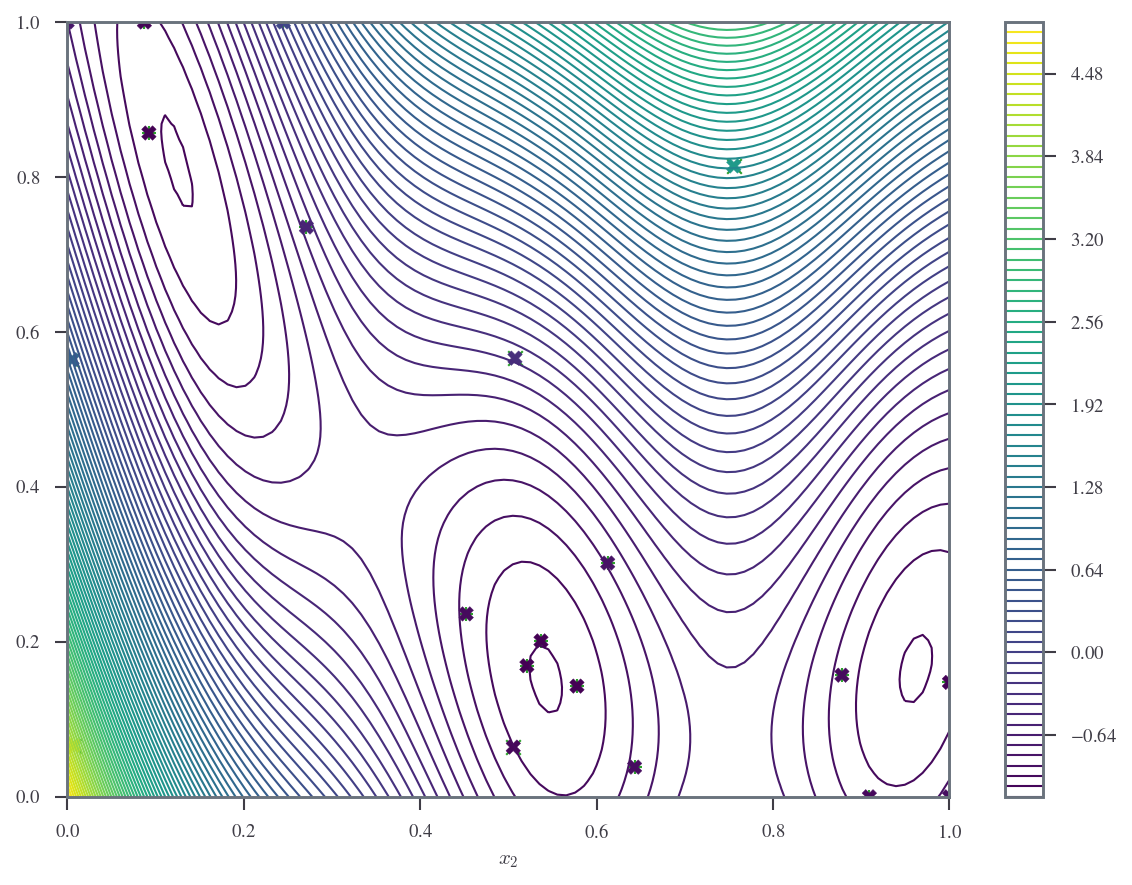

In [7]:
bo_optimize(15)

In [7]:
constraints_d = {
    "angle": {"min": -80, "max": 80, "units": "degrees"},
    "trans_speed": {"min": 0, "max": 15, "units": "m/s"},
    "displacement": {"min": -2, "max": 2, "units": "degrees"},
    "order": ("angle", "trans_speed", "displacement"),
}
# constraints_l =

In [8]:
from adbo.rescale import rescale, rescale_inverse

In [9]:
[i for i in constraints_d["order"]]

['angle', 'trans_speed', 'displacement']

In [10]:
rescale_inverse(np.array([[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]]), constraints_d)

input [[0.5 0.5 0.5]
 [0.5 0.5 0.5]]
config {'angle': {'min': -80, 'max': 80, 'units': 'degrees'}, 'trans_speed': {'min': 0, 'max': 15, 'units': 'm/s'}, 'displacement': {'min': -2, 'max': 2, 'units': 'degrees'}, 'order': ('angle', 'trans_speed', 'displacement')}
(3,) (3,) (2, 3) (2,)


array([[0. , 7.5, 0. ],
       [0. , 7.5, 0. ]])

In [11]:
rescale_inverse(np.array([[0.5, 0.5, 0.5]]), constraints_d)

input [[0.5 0.5 0.5]]
config {'angle': {'min': -80, 'max': 80, 'units': 'degrees'}, 'trans_speed': {'min': 0, 'max': 15, 'units': 'm/s'}, 'displacement': {'min': -2, 'max': 2, 'units': 'degrees'}, 'order': ('angle', 'trans_speed', 'displacement')}
(3,) (3,) (1, 3) (1,)


array([[0. , 7.5, 0. ]])

In [12]:
rescale_inverse(np.array([[0.5, 0.5, 0.5]]).T, constraints_d)

input [[0.5]
 [0.5]
 [0.5]]
config {'angle': {'min': -80, 'max': 80, 'units': 'degrees'}, 'trans_speed': {'min': 0, 'max': 15, 'units': 'm/s'}, 'displacement': {'min': -2, 'max': 2, 'units': 'degrees'}, 'order': ('angle', 'trans_speed', 'displacement')}
(3,) (3,) (3, 1) (3,)


array([[0. , 7.5, 0. ],
       [0. , 7.5, 0. ],
       [0. , 7.5, 0. ]])

In [24]:
import os
from adforce.wrap import run_wrapped
from sithom.io import write_json
from src.constants import NEW_ORLEANS

ROOT: str = "/work/n01/n01/sithom/adcirc-swan/"


def observer_f(config, exp_name="bo_test"):
    # set up folder for all experiments
    exp_dir = os.path.join(ROOT, exp_name)
    os.makedirs(exp_dir, exist_ok=True)
    call_number = -1
    output = {}

    def temp_dir() -> str:
        nonlocal exp_dir
        tmp_dir = os.path.join(exp_dir, f"exp_{call_number:04}")
        os.makedirs(tmp_dir, exist_ok=True)
        return tmp_dir

    def add_query_to_output(real_query, real_result) -> None:
        nonlocal output
        output[call_number] = {
            "dir": temp_dir(),
            "res": real_result,
            **{name: float(real_query[j]) for j, name in enumerate(config["order"])},
        }
        write_json(output, os.path.join(exp_dir, "experiments.json"))

    def obs(queries: np.ndarray) -> np.ndarray:
        nonlocal call_number
        # put in real space
        returned_results = []
        real_queries = rescale_inverse(queries, config)
        for i in range(real_queries.shape[0]):
            call_number += 1
            tmp_dir = temp_dir()
            inputs = {
                name: float(real_queries[i][j])
                for j, name in enumerate(config["order"])
            }
            inputs["impact_lon"] = NEW_ORLEANS.lon + inputs["displacement"]
            del inputs["displacement"]
            real_result = run_wrapped(out_path=tmp_dir, **inputs)
            add_query_to_output(real_queries[i], real_result)
            # flip sign to make it a minimisation problem
            returned_results.append(-real_result)

        return np.array(returned_results)
        # run the model
        # return the result

    return obs

In [26]:
# set up BayesOpt
search_space = trieste.space.Box([0, 0, 0], [1, 1, 1])
initial_query_points = search_space.sample_sobol(3)
observer = observer_f(constraints_d)
initial_data = observer(initial_query_points)
gpr = trieste.models.gpflow.build_gpr(initial_data, search_space)
model = trieste.models.gpflow.GaussianProcessRegression(gpr)

input tf.Tensor(
[[0.7922821  0.53083801 0.46647644]
 [0.5422821  0.28083801 0.71647644]
 [0.0422821  0.78083801 0.21647644]], shape=(3, 3), dtype=float64)
config {'angle': {'min': -80, 'max': 80, 'units': 'degrees'}, 'trans_speed': {'min': 0, 'max': 15, 'units': 'm/s'}, 'displacement': {'min': -2, 'max': 2, 'units': 'degrees'}, 'order': ('angle', 'trans_speed', 'displacement')}
(3,) (3,) (3, 3) (3,)
f22_dt DataTree('None', parent=None)
│   Dimensions:  ()
│   Data variables:
│       *empty*
│   Attributes:
│       group_order:  Main TC1
│       institution:  Oceanweather Inc. (OWI)
│       conventions:  CF-1.6 OWI-NWS13
├── DataTree('Main')
│       Dimensions:  (yi: 385, xi: 393, time: 673)
│       Coordinates:
│           lat      (yi, xi) float64 ...
│           lon      (yi, xi) float64 ...
│         * time     (time) datetime64[ns] 2004-08-09 2004-08-09T00:15:00 ... 2004-08-16
│       Dimensions without coordinates: yi, xi
│       Data variables:
│           PSFC     (time, yi, xi

b'Submitted batch job 5803027'


Job 5803027 finished
'run_and_wait'  07 min 42 s 

'xr_loader'  0.10146 s 

'run_wrapped'  07 min 58 s 



TypeError: Object of type EagerTensor is not JSON serializable